# **Multi-Model CLIP Guided Generation Using Stable Diffusion**

In [ ]:
!pip install transformers

## CLIP Tokenizer and CLIP Text Model

In [7]:
from transformers import CLIPTokenizer, CLIPTextModel

In [8]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Stable Diffusion for Image Generation

In [9]:
from diffusers import StableDiffusionPipeline

In [10]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")
pipe.text_encoder = text_encoder
pipe.tokenizer = tokenizer

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [123]:
prompt = 'A boy swimming in the pool'

In [124]:
image = pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

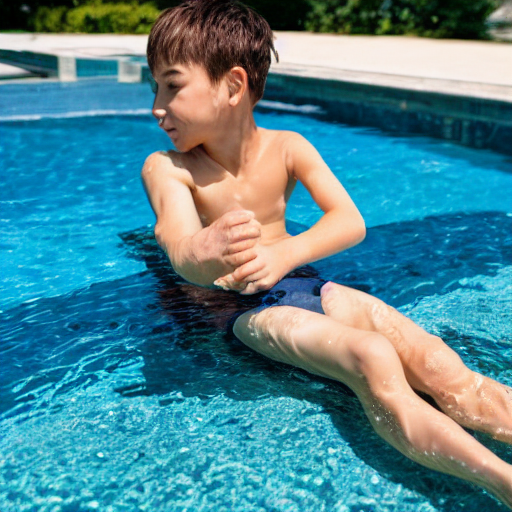

In [125]:
from IPython.display import display

display(image)


## Blip Processor and Blip for Conditional Generation for **Image Captioning**

In [127]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

In [128]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to('cuda')

In [130]:
raw_image = image.convert("RGB")
inputs = processor(images=raw_image, return_tensors="pt").to('cuda')
caption_ids = model.generate(**inputs)
generated_caption = processor.decode(caption_ids[0], skip_special_tokens=True)
print("Back Caption: ", generated_caption)

Back Caption:  a boy in a swimming pool


In [131]:
from transformers import CLIPProcessor, CLIPModel
import torch

In [132]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
processer = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

## Cosine Similarity between Prompt and Generated Caption

In [133]:
inputs = processer(text=[prompt, generated_caption], images=image, return_tensors='pt', padding=True).to('cuda')
outputs = model(**inputs)
text_embeds = outputs.text_embeds
similarity = torch.nn.functional.cosine_similarity(text_embeds[0], text_embeds[1], dim=0).item()
print(f"Cosine Similarity of prompt and generated_text: {similarity:.4f}" )

Cosine Similarity of prompt and generated_text: 0.9491


## Image Generation Using Generated Caption

In [134]:
generated_image = pipe(generated_caption).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

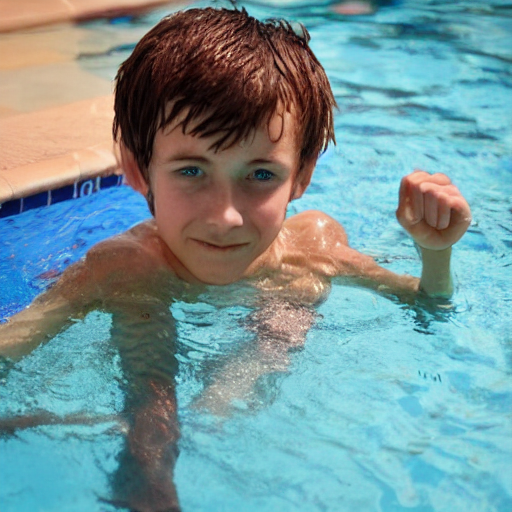

In [135]:
display(generated_image)

In [136]:
# !pip install git+https://github.com/openai/CLIP.git

In [137]:
import torch
from torchvision import transforms
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"

## Cosine Similarity between **Image from Prompt** and **Image from Generated Caption**

In [138]:
model, preprocess = clip.load("ViT-B/32", device)

In [139]:
image1 = preprocess(image).unsqueeze(0).to(device)
image2 = preprocess(generated_image).unsqueeze(0).to(device)

In [140]:
with torch.no_grad():
  img1_embed = model.encode_image(image1)
  img2_embed = model.encode_image(image2)

similarity = torch.nn.functional.cosine_similarity(img1_embed, img2_embed).item()
print(f"CLIP Cosine Similarity of image from prompt and image from generated_caption: {similarity:.4f}")

CLIP Cosine Similarity of image from prompt and image from generated_caption: 0.8911
